# Using autoencoders to detect anamolies.

In this part, we use the same dataset. Here we use 3 kinds of autoencoders to detect anamolies 
1. Conv1d and conv1d transpose 
2. Dense autoencoder
3. LSTM based autoencoder

I found that LSTM based model worked best and further performed hyper parameter tuning on it.

In [2]:
#!conda activate tf-gpu
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md


In [3]:
#!pip install --upgrade tensorflow
tf.__version__

'2.3.0'

In [4]:
data = pd.read_csv('data.csv')

In [5]:
data

,timestamp,value
0,2015-08-31 18:22:00,90
1,2015-08-31 18:32:00,80
2,2015-08-31 18:57:00,84
3,2015-08-31 19:07:00,94
4,2015-08-31 19:12:00,90
...,...,...
2495,2015-09-17 16:04:00,81
2496,2015-09-17 16:09:00,89
2497,2015-09-17 16:14:00,87
2498,2015-09-17 16:19:00,82


In [6]:
data.describe()

,value
count,2500.000000
mean,81.906800
std,8.746606
min,20.000000
25%,77.000000
50%,82.000000
75%,88.000000
max,109.000000


In [7]:
no_anamolies = data.drop(data[(data.value < 50) | (data.value > 90)].index)


In [9]:
anamolies = data

In [11]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()

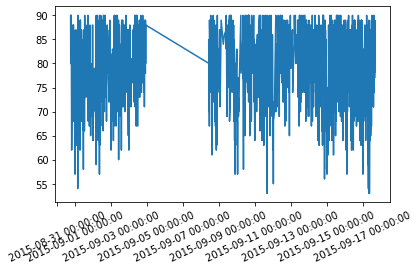

In [12]:
plot_dates_values(no_anamolies)

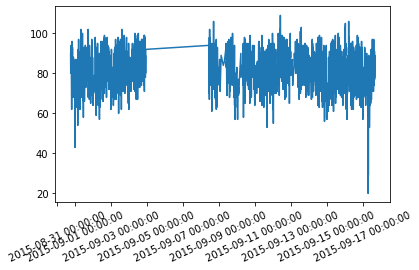

In [54]:
plot_dates_values(anamolies)

In [13]:
def get_value_from_df(df):
    return df.value.to_list()


def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std


# Get the `value` column from the training dataframe.
training_value = get_value_from_df(no_anamolies)

# Normalize `value` and save the mean and std we get,
# for normalizing test data.
training_value, training_mean, training_std = normalize(training_value)
len(training_value)

2100

In [14]:
TIME_STEPS = 5


def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    # Convert 2D sequences into 3D as we will be feeding this into
    # a convolutional layer.
    return np.expand_dims(output, axis=2)


x_train = create_sequences(training_value)
X_train = np.asarray(x_train)
print("Training input shape: ", X_train.shape)

Training input shape:  (2095, 5, 1)


In [57]:
X_train

array([[[ 1.44619074],
        [ 0.03919488],
        [ 0.60199323],
        [ 1.44619074],
        [-2.49339766]],

       [[ 0.03919488],
        [ 0.60199323],
        [ 1.44619074],
        [-2.49339766],
        [-0.66430304]],

       [[ 0.60199323],
        [ 1.44619074],
        [-2.49339766],
        [-0.66430304],
        [ 0.60199323]],

       ...,

       [[ 0.03919488],
        [-0.38290387],
        [ 0.32059406],
        [ 0.17989447],
        [ 1.30549116]],

       [[-0.38290387],
        [ 0.32059406],
        [ 0.17989447],
        [ 1.30549116],
        [ 1.02409198]],

       [[ 0.32059406],
        [ 0.17989447],
        [ 1.30549116],
        [ 1.02409198],
        [ 0.32059406]]])

This is the 1D conv autoencoder.

In [77]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=2, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1D(
            filters=16, kernel_size=2, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=2, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=32, kernel_size=2, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 5, 32)             96        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5, 16)             1040      
_________________________________________________________________
conv1d_transpose_12 (Conv1DT (None, 5, 16)             528       
_________________________________________________________________
conv1d_transpose_13 (Conv1DT (None, 5, 32)             1056      
_________________________________________________________________
conv1d_transpose_14 (Conv1DT (None, 5, 1)              225       
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
15/15 [==============================] - 0s 17ms/step - loss: 0.8679 - val_loss: 0.9905
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.5892 - val_loss: 0.4045
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.2519 - val_loss: 0.1663
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1139 - val_loss: 0.0875
Epoch 5/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0673 - val_loss: 0.0569
Epoch 6/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0457 - val_loss: 0.0411
Epoch 7/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0330 - val_loss: 0.0281
Epoch 8/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0234 - val_loss: 0.0190
Epoch 9/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0137
Epoch 10/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0100
Epoch 11/50
15/15 

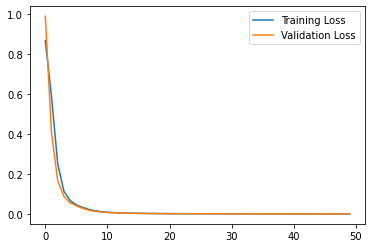

In [79]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

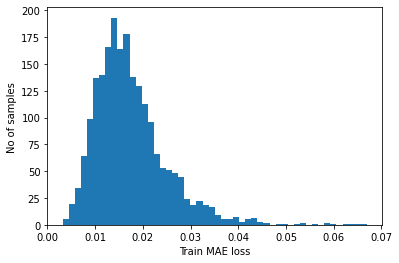

Reconstruction error threshold:  0.06696700618398066


In [61]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

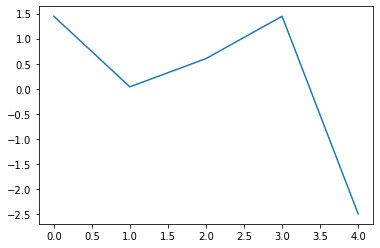

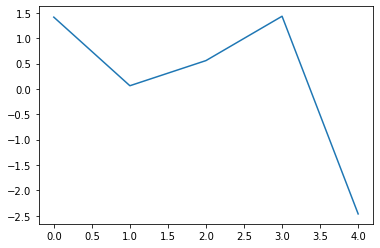

In [62]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

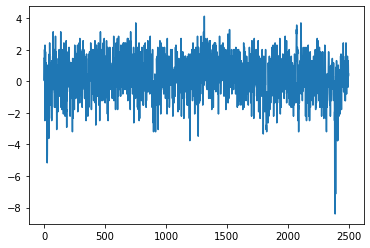

Test input shape:  (2495, 5, 1)


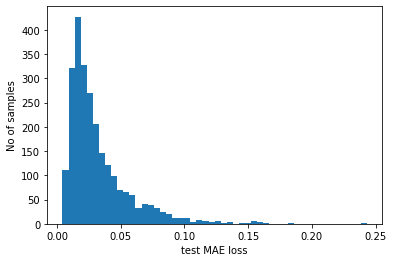

Number of anomaly samples:  235
Indices of anomaly samples:  (array([   7,   42,   45,   70,   72,   73,   74,   86,   89,   90,   92,
         93,  133,  134,  135,  136,  159,  160,  163,  164,  177,  180,
        181,  274,  284,  286,  287,  289,  290,  292,  295,  316,  319,
        320,  382,  417,  429,  442,  443,  446,  457,  459,  460,  461,
        462,  490,  492,  493,  511,  512,  522,  539,  563,  569,  571,
        590,  591,  597,  598,  601,  607,  611,  630,  647,  650,  657,
        658,  660,  669,  674,  675,  680,  684,  688,  692,  693,  707,
        708,  709,  710,  734,  748,  749,  750,  751,  752,  764,  779,
        822,  828,  830,  838,  847,  848,  851,  857,  867,  868,  870,
        871,  890,  933,  946,  947,  948,  950,  951,  959,  962, 1011,
       1039, 1051, 1078, 1120, 1121, 1124, 1246, 1255, 1259, 1263, 1267,
       1285, 1286, 1288, 1289, 1290, 1298, 1300, 1304, 1305, 1306, 1307,
       1309, 1311, 1312, 1313, 1314, 1315, 1316, 1320, 1329, 1

In [63]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(anamolies)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [64]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

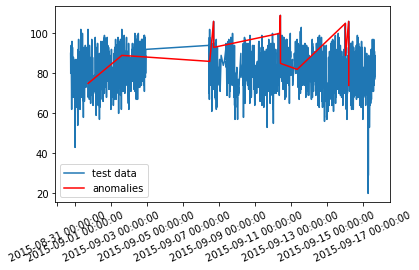

In [65]:
df_subset = anamolies.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = anamolies["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = anamolies["value"].to_list()
plt.plot(dates, values, label="test data")F

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

As we can see this model detected 235 points as anamolies. The results arent ideal but it managed to detect a few points above 90 as anamolies.

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import  Dense,Dropout

In [67]:
model = Sequential()

model.add(Dense(512,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))

model.add(Dense(16,activation = 'relu'))

model.add(Dense(32,activation = 'relu'))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(512,activation = 'relu'))

model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics = [accuracy])


In [68]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min",verbose =1)
    ],
)

Epoch 1/50
15/15 [==============================] - 1s 39ms/step - loss: 1.0579 - val_loss: 1.3101
Epoch 2/50
15/15 [==============================] - 0s 21ms/step - loss: 0.6062 - val_loss: 1.1226
Epoch 3/50
15/15 [==============================] - 0s 20ms/step - loss: 0.5774 - val_loss: 1.1201
Epoch 4/50
15/15 [==============================] - 0s 20ms/step - loss: 0.5745 - val_loss: 1.1187
Epoch 5/50
15/15 [==============================] - 0s 21ms/step - loss: 0.5734 - val_loss: 1.1184
Epoch 6/50
15/15 [==============================] - 0s 19ms/step - loss: 0.5732 - val_loss: 1.1184
Epoch 7/50
15/15 [==============================] - 0s 20ms/step - loss: 0.5730 - val_loss: 1.1182
Epoch 8/50
15/15 [==============================] - 0s 20ms/step - loss: 0.5730 - val_loss: 1.1182
Epoch 9/50
15/15 [==============================] - 0s 20ms/step - loss: 0.5729 - val_loss: 1.1181
Epoch 10/50
15/15 [==============================] - 0s 20ms/step - loss: 0.5729 - val_loss: 1.1182
Epoch 11/

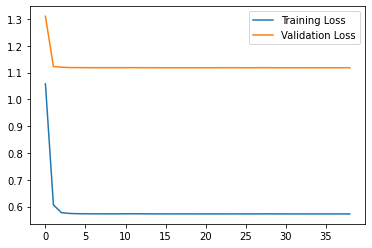

In [69]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

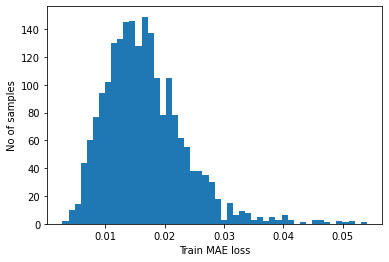

Reconstruction error threshold:  0.05409148583337466


In [81]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

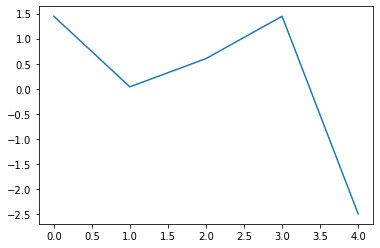

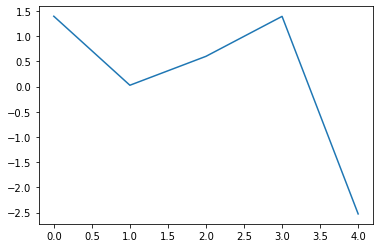

In [82]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

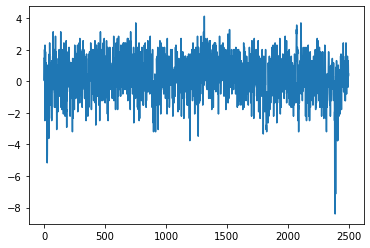

Test input shape:  (2495, 5, 1)


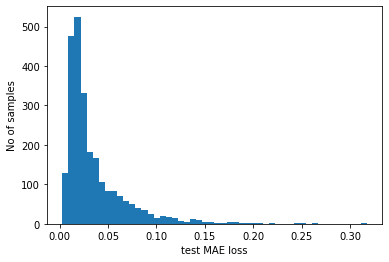

Number of anomaly samples:  482
Indices of anomaly samples:  (array([   4,    5,    6,    7,   23,   38,   41,   45,   70,   71,   72,
         73,   74,   84,   85,   86,   87,   88,   89,   90,   92,   93,
        126,  132,  133,  135,  136,  144,  147,  158,  159,  160,  161,
        162,  163,  164,  177,  178,  180,  181,  200,  204,  247,  248,
        251,  266,  270,  274,  280,  281,  283,  284,  285,  286,  287,
        289,  291,  292,  293,  295,  316,  317,  318,  319,  320,  325,
        329,  378,  379,  381,  382,  399,  402,  408,  409,  410,  413,
        414,  416,  417,  425,  426,  427,  428,  429,  436,  442,  444,
        446,  455,  456,  458,  459,  460,  461,  462,  471,  481,  485,
        489,  490,  493,  502,  508,  509,  510,  511,  512,  522,  534,
        537,  538,  539,  561,  562,  563,  566,  567,  568,  571,  587,
        588,  589,  590,  591,  597,  598,  599,  601,  607,  611,  626,
        627,  628,  629,  630,  638,  639,  641,  642,  646,  

In [83]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(anamolies)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [84]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

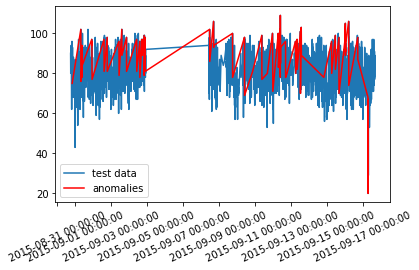

In [85]:
df_subset = anamolies.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = anamolies["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = anamolies["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

This model detected 482 points as anamolies. This detects most of the points above 90 and below 50 as anamolies but it also detects a few points that are not anamolies as anamolies

In [86]:
#!pip install --upgrade keras

In [30]:
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [32]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(5,1), return_sequences=True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(5))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 128)            66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 64)             33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 128)            98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 1)              129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
________________________________________________

In [33]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min",verbose =1)
    ],
)

Epoch 1/50
15/15 [==============================] - 1s 83ms/step - loss: 0.9467 - val_loss: 1.3058
Epoch 2/50
15/15 [==============================] - 1s 48ms/step - loss: 0.8372 - val_loss: 1.0033
Epoch 3/50
15/15 [==============================] - 1s 49ms/step - loss: 0.7526 - val_loss: 0.9155
Epoch 4/50
15/15 [==============================] - 1s 48ms/step - loss: 0.6912 - val_loss: 0.8224
Epoch 5/50
15/15 [==============================] - 1s 49ms/step - loss: 0.6677 - val_loss: 0.7661
Epoch 6/50
15/15 [==============================] - 1s 47ms/step - loss: 0.6369 - val_loss: 0.7131
Epoch 7/50
15/15 [==============================] - 1s 49ms/step - loss: 0.6022 - val_loss: 0.6436
Epoch 8/50
15/15 [==============================] - 1s 47ms/step - loss: 0.5714 - val_loss: 0.5943
Epoch 9/50
15/15 [==============================] - 1s 47ms/step - loss: 0.5391 - val_loss: 0.5394
Epoch 10/50
15/15 [==============================] - 1s 47ms/step - loss: 0.5165 - val_loss: 0.4928
Epoch 11/

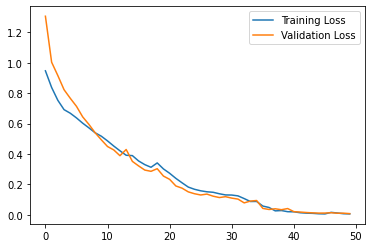

In [34]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

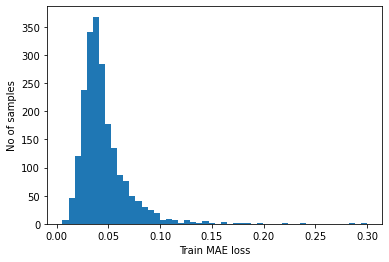

Reconstruction error threshold:  0.29976086511111677


In [35]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

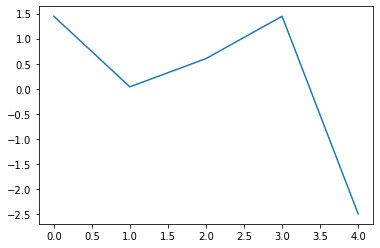

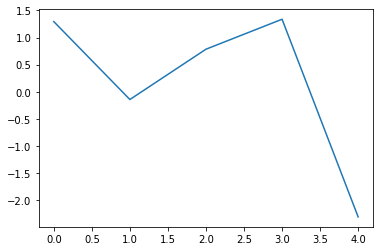

In [36]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

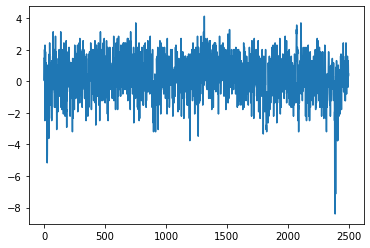

Test input shape:  (2495, 5, 1)


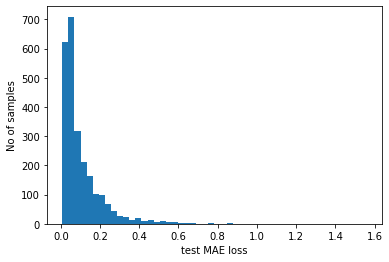

Number of anomaly samples:  153
Indices of anomaly samples:  (array([   6,   24,   25,   42,   44,   71,   72,   73,   92,  133,  135,
        146,  161,  162,  179,  180,  182,  250,  273,  284,  292,  293,
        294,  319,  415,  416,  428,  445,  459,  460,  461,  484,  490,
        492,  509,  511,  521,  568,  570,  590,  599,  600,  601,  610,
        629,  649,  654,  655,  657,  668,  683,  687,  692,  707,  708,
        709,  710,  734,  748,  749,  750,  751,  752,  763,  829,  850,
        870,  933,  949, 1010, 1123, 1124, 1257, 1258, 1259, 1266, 1287,
       1288, 1289, 1297, 1299, 1305, 1306, 1307, 1308, 1311, 1312, 1313,
       1314, 1315, 1317, 1318, 1319, 1328, 1338, 1339, 1356, 1362, 1385,
       1403, 1405, 1439, 1467, 1508, 1514, 1515, 1517, 1519, 1520, 1521,
       1522, 1582, 1637, 1705, 1724, 1756, 1879, 1895, 1910, 1934, 1978,
       1989, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2080, 2104, 2105,
       2106, 2107, 2108, 2110, 2241, 2247, 2259, 2264, 2382, 2

In [37]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(anamolies)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [38]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

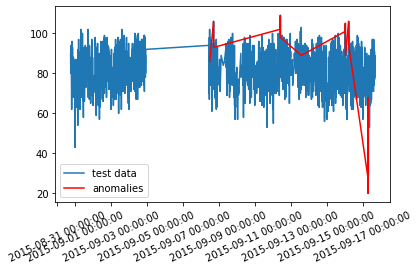

In [39]:
df_subset = anamolies.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = anamolies["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = anamolies["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

LSTM Detects fewer points as anamolies. But it is much more stable. For the most part it only detects the points above 90 and below 50.

# **Hyperparameter tuning**

In this section, we use tune the hyper parameters of the conv1d autoencoder model. There is no particular reason for taking the conv1d model for this part. 

Initailly I used the tanh activation function instead of relu function for all the layers. 

In [112]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=2, padding="same", strides=1, activation="tanh"
        ),
        layers.Conv1D(
            filters=16, kernel_size=2, padding="same", strides=1, activation="tanh"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=2, padding="same", strides=1, activation="tanh"
        ),
        layers.Conv1DTranspose(
            filters=32, kernel_size=2, padding="same", strides=1, activation="tanh"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 5, 32)             96        
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 5, 16)             1040      
_________________________________________________________________
conv1d_transpose_27 (Conv1DT (None, 5, 16)             528       
_________________________________________________________________
conv1d_transpose_28 (Conv1DT (None, 5, 32)             1056      
_________________________________________________________________
conv1d_transpose_29 (Conv1DT (None, 5, 1)              225       
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [113]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
15/15 [==============================] - 0s 20ms/step - loss: 0.6830 - val_loss: 0.4365
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.2223 - val_loss: 0.1923
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1063 - val_loss: 0.1420
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0787 - val_loss: 0.1198
Epoch 5/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0651 - val_loss: 0.0984
Epoch 6/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0560 - val_loss: 0.0889
Epoch 7/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0478 - val_loss: 0.0773
Epoch 8/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0411 - val_loss: 0.0664
Epoch 9/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.0588
Epoch 10/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.0513
Epoch 11/50
15/15 

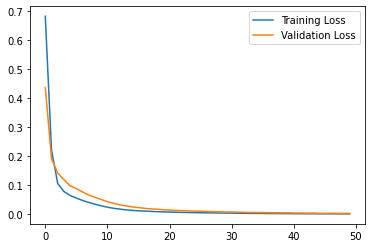

In [114]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

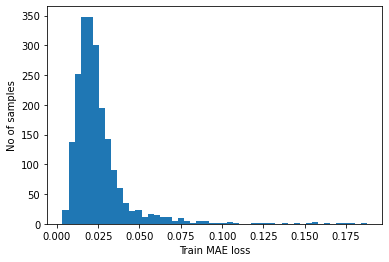

Reconstruction error threshold:  0.1875354948711319


In [115]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

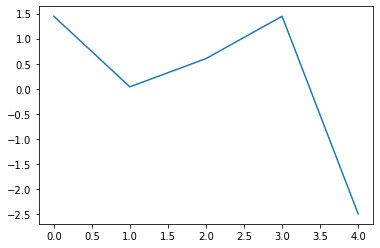

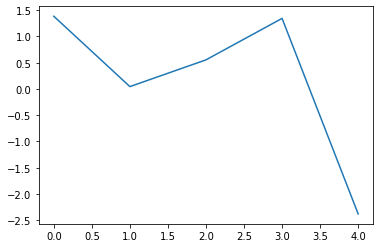

In [116]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

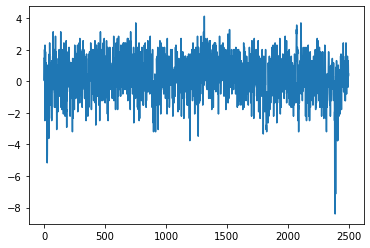

Test input shape:  (2495, 5, 1)


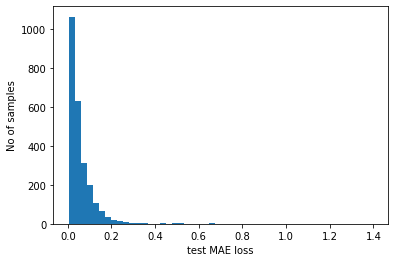

Number of anomaly samples:  87
Indices of anomaly samples:  (array([   3,   21,   22,   23,   24,   25,   26,   70,   72,  134,  135,
        136,  161,  162,  180,  181,  292,  293,  416,  458,  459,  460,
        461,  462,  657,  684,  706,  707,  708,  709,  710,  748,  749,
        750,  751,  752,  932,  933,  950, 1258, 1259, 1263, 1264, 1265,
       1288, 1289, 1304, 1305, 1306, 1307, 1308, 1309, 1311, 1312, 1313,
       1314, 1315, 1316, 1339, 1518, 1522, 1907, 2067, 2068, 2069, 2070,
       2071, 2072, 2073, 2074, 2104, 2105, 2106, 2107, 2108, 2382, 2383,
       2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393]),)


In [117]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(anamolies)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [118]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

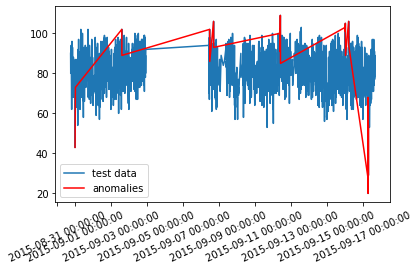

In [119]:
df_subset = anamolies.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = anamolies["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = anamolies["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

This model worked a little okay. It detected a few points below 50 and above 90 as anamolies. But it also detected a few non-anamolous points as anamolies

Next let us use leaky relu activation function

In [15]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=2, padding="same", strides=1, 
        ),layers.LeakyReLU(),
        #layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=2, padding="same", strides=1, 
        ),layers.LeakyReLU(),
        layers.Conv1DTranspose(
            filters=16, kernel_size=2, padding="same", strides=1,
        ),layers.LeakyReLU(),
        #layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=2, padding="same", strides=1, 
        ),layers.LeakyReLU(),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 32)             96        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 32)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 16)             1040      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 16)             0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 5, 16)             528       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 5, 16)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 5, 32)             1

In [16]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
15/15 [==============================] - 0s 22ms/step - loss: 0.8710 - val_loss: 1.1119
Epoch 2/50
15/15 [==============================] - 0s 5ms/step - loss: 0.5598 - val_loss: 0.5451
Epoch 3/50
15/15 [==============================] - 0s 5ms/step - loss: 0.2025 - val_loss: 0.1662
Epoch 4/50
15/15 [==============================] - 0s 5ms/step - loss: 0.1038 - val_loss: 0.1104
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0721 - val_loss: 0.0818
Epoch 6/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0547 - val_loss: 0.0642
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0512
Epoch 8/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0354 - val_loss: 0.0406
Epoch 9/50
15/15 [==============================] - 0s 5ms/step - loss: 0.0285 - val_loss: 0.0318
Epoch 10/50
15/15 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0250
Epoch 11/50
15/15 

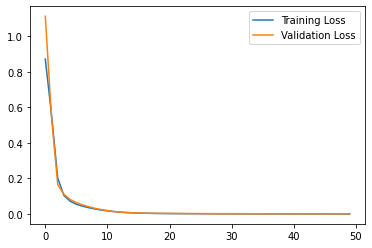

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

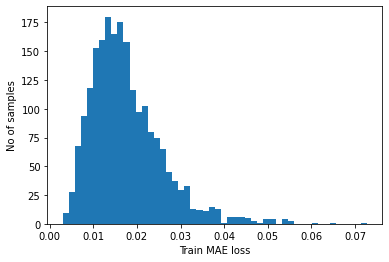

Reconstruction error threshold:  0.07272455016034954


In [18]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

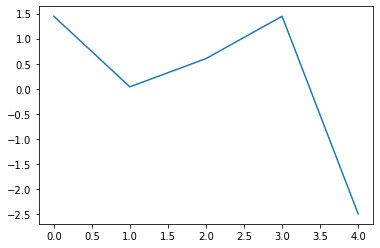

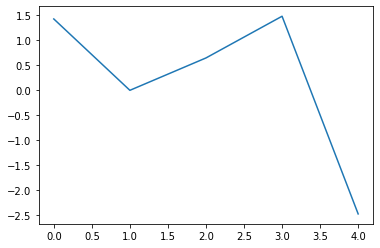

In [19]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

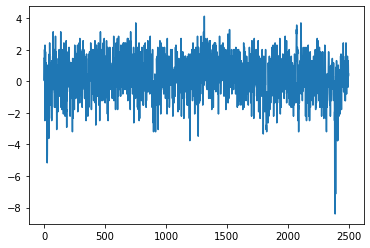

Test input shape:  (2495, 5, 1)


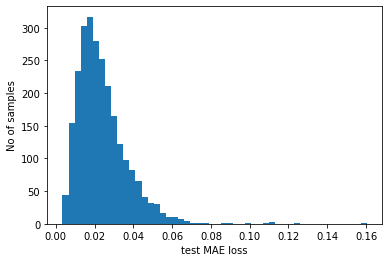

Number of anomaly samples:  11
Indices of anomaly samples:  (array([ 686, 1518, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390]),)


In [20]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(anamolies)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [21]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

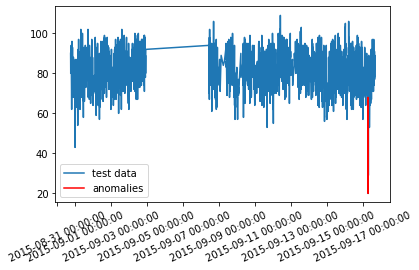

In [22]:
df_subset = anamolies.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = anamolies["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = anamolies["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

THis model performs very badly. It detects only the points at the end most of which are less then 50 as anamolies. But it misses a lot of points. 

Let us go back to relu but try increasing the number of layers. And also the kernal size and strides for a few layers

In [225]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        
     layers.Conv1D(
            filters=64, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1D(
            filters=32, kernel_size=2, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1D(
            filters=16, kernel_size=2, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=2, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=32, kernel_size=2, padding="same", strides=1, activation="relu"
        ),
     layers.Conv1DTranspose(
            filters=64, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        
        layers.Conv1DTranspose(filters=1, kernel_size=5, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_101 (Conv1D)          (None, 5, 64)             384       
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 5, 32)             4128      
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 5, 16)             1040      
_________________________________________________________________
conv1d_transpose_127 (Conv1D (None, 5, 16)             528       
_________________________________________________________________
conv1d_transpose_128 (Conv1D (None, 5, 32)             1056      
_________________________________________________________________
conv1d_transpose_129 (Conv1D (None, 5, 64)             10304     
_________________________________________________________________
conv1d_transpose_130 (Conv1D (None, 5, 1)            

In [226]:
history = model.fit(
    x_train,
    x_train,
    epochs=150,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)

Epoch 1/150
59/59 [==============================] - 0s 8ms/step - loss: 0.3294 - val_loss: 0.0438
Epoch 2/150
59/59 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.0067
Epoch 3/150
59/59 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 4/150
59/59 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 5/150
59/59 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 6/150
59/59 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 7/150
59/59 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 8/150
59/59 [==============================] - 0s 5ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/150
59/59 [==============================] - 0s 5ms/step - loss: 9.7329e-04 - val_loss: 0.0016
Epoch 10/150
59/59 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch

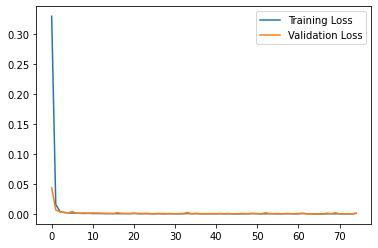

In [227]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

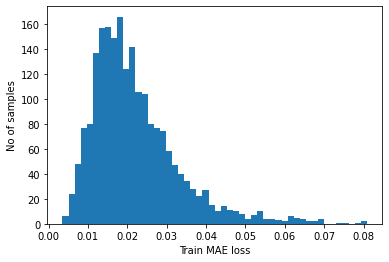

Reconstruction error threshold:  0.0808287539813946


In [228]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

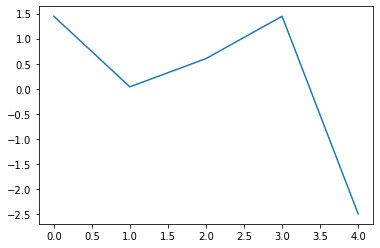

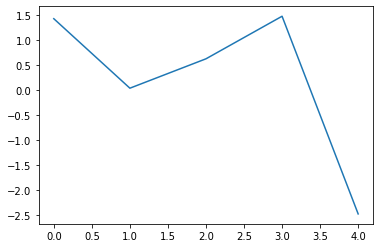

In [229]:
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

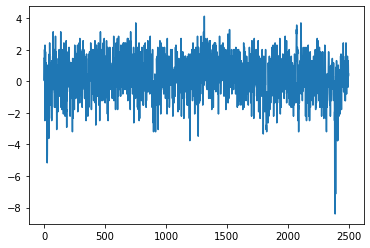

Test input shape:  (2495, 5, 1)


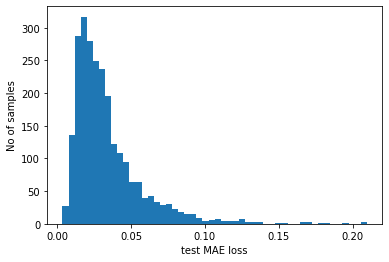

Number of anomaly samples:  121
Indices of anomaly samples:  (array([  22,   23,   25,   45,   74,   93,  135,  136,  180,  181,  204,
        294,  295,  319,  320,  382,  416,  417,  446,  461,  462,  485,
        493,  511,  512,  522,  571,  591,  600,  601,  611,  630,  650,
        657,  660,  669,  684,  692,  693,  709,  710,  749,  751,  752,
        764,  779,  830,  851,  871,  932,  933,  950,  951,  959, 1011,
       1124, 1235, 1246, 1258, 1259, 1267, 1289, 1290, 1298, 1300, 1305,
       1308, 1309, 1312, 1315, 1316, 1320, 1329, 1339, 1342, 1357, 1363,
       1398, 1440, 1465, 1468, 1471, 1509, 1515, 1521, 1522, 1539, 1685,
       1706, 1725, 1757, 1896, 1935, 1979, 1983, 1990, 2069, 2070, 2071,
       2072, 2073, 2074, 2080, 2106, 2107, 2108, 2150, 2242, 2248, 2259,
       2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392]),)


In [230]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(anamolies)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [231]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

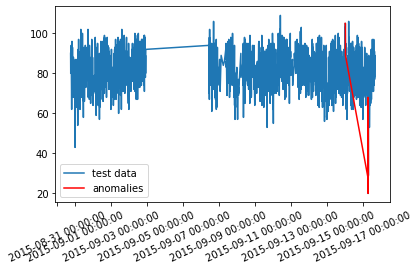

In [236]:
df_subset = anamolies.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = anamolies["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = anamolies["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

This looks like a acceptabel model. It is detecting 120 points as anamolies. It is also detecting a few points at the begginining as anamolies but they arent displayed in the graph most probably because they are individual points seperate from each other. 

Overall I think that the LSTM model is the best for reconstructing time series data and for detecting anamolies. I would like to continue tuning the LSTM model that I developed for achiving better results later

## References:

https://blog.keras.io/building-autoencoders-in-keras.html
https://keras.io/examples/timeseries/timeseries_anomaly_detection/
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
https://machinelearningmastery.com/lstm-autoencoders/
https://github.com/numenta/NAB/tree/master/data
https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352
https://medium.com/analytics-vidhya/types-of-distances-in-machine-learning-5b1233380775
